In [451]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
import os
import numpy as np
import time
import re
import h5py
import scipy.io as spio
import scipy as sp

import sys
import seaborn
seaborn.set(font_scale=2)
seaborn.set_style('whitegrid')
clrs = seaborn.color_palette()
from multiprocessing.dummy import Pool
import scipy.spatial.distance as dst
from scipy.stats import multivariate_normal


sys.path.append('/home/yves/Documents/')
import twoptb as MP

kernel = lambda x1,x2: k*np.exp((-.5)*((x1-x2)**2)/l**2)

##  Helper Functions from Previous Stuff

In [452]:
def get_sqdists(x,y=None):
    
    if type(y)!=np.ndarray:
        if x.ndim==1:
            dists = dst.pdist(np.vstack([x,np.zeros(x.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.pdist(x)
            
        dists = dst.squareform(dists)
        
    else:
        if x.ndim==1:
            dists = dst.cdist(np.vstack([x,np.zeros(x.shape)]).T,np.vstack([y,np.zeros(y.shape)]).T,metric='sqeuclidean')
        else:
            dists = dst.cdist(x,y)
    return dists

In [453]:
def calc_K(x,y=None,l=.5,add_offset=1e-3,reshape_params=None):
    
        
    distsSq = get_sqdists(x,y)
    
    cov = (1-add_offset)*np.exp(-.5*distsSq/(l**2)) 
    
    cov += np.eye(len(x))*add_offset
    return cov

#  Implements the E-Step of GPFA

In [454]:
n_neurons = 200 #q
hiddenDim = 12 #p
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
T_max = len(t)

tav = np.random.randint(1,3,size=hiddenDim)
sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.array([5*np.arange(0,n_neurons),
              np.abs(45 - 5*np.arange(0,n_neurons,))])#
C = np.random.randint(-20,20,size=(n_neurons,hiddenDim))/2
d = np.random.randint(40,50,size=(n_neurons))



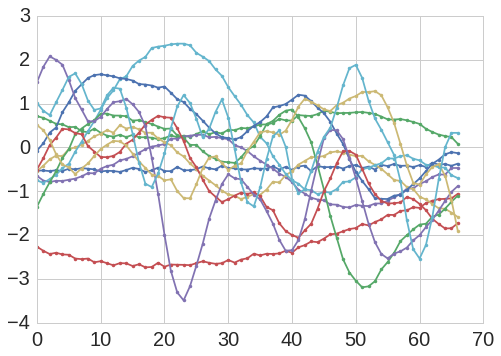

In [455]:
x = np.zeros([hiddenDim,T_max])

length_scales_GP = [10**(1 if i== 0 else .5-i*.1) for i in range(hiddenDim)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[0]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()#*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(T_max-35),np.cos(np.linspace(0,.5*np.pi,num=5)),np.zeros(10)])

for i in range(hiddenDim):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
y = C.dot(x) + d[:,None] + np.random.normal(loc=0,scale=5,size=(n_neurons,T_max))

In [456]:
data = {}
ground_truth = {'C':C,
                'd':d,
                'l':length_scales_GP,
                'x':x}

In [457]:
#Here are the random hidden states data is being drawn from
X_bar = np.array([x.T.flatten()])


In [458]:
params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [459]:
def make_Cbig(C,t):
    return np.kron(np.eye(len(t)),C)

In [460]:
params['C'].shape

(200, 12)

In [478]:
def make_Kbig(params,t,epsNoise=1e-3):

    epsSignal = (1-epsNoise)
    nT = len(t)  #number of time points
    nDims = params['C'].shape[1] #dimensionality of the latent space
    #nT is
    K_big = np.zeros([nT*nDims,nT*nDims])  
    R_big = np.zeros([nT*nDims,nT*nDims]) 

    for dim in range(nDims):

        for t1_idx,t1 in enumerate(t):

            for t2_idx,t2 in enumerate(t):

                K_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = epsSignal*np.exp((-0.5)*((t1-t2)**2/(params['l'][dim])**2))
                R_big[dim+t1_idx*nDims,dim+t2_idx*nDims] = 1
    return K_big, R_big


In [479]:
K_big,_ = make_Kbig(params,t)
C_big = make_Cbig(C,t)

In [480]:
st = time.time()
n = K_big.dot(C_big.T).dot(np.linalg.inv(C_big.dot(K_big).dot(C_big.T) + 1e-3*np.eye(T_max*n_neurons))).dot(y.T.flatten(order='C') - np.tile(d,T_max))
print time.time() - st

0.499795913696


IndexError: index 4 is out of bounds for axis 0 with size 4

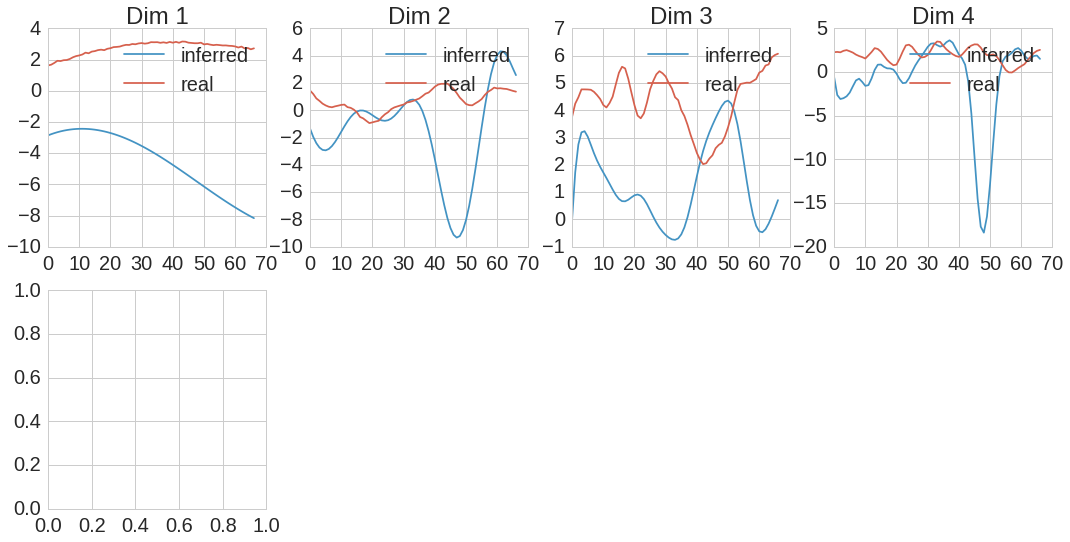

In [659]:
newN = n.T.reshape(-1,67,order='F')
plt.figure(figsize=(18,18))
clrs = seaborn.color_palette('RdBu',n_colors=4)

nRows, nCols= [np.ceil(np.sqrt(hiddenDim)).astype('int')]*2
for i in range(hiddenDim):
    plt.title('Dim %s' %i)
    plt.subplot(nRows,nCols,i+1)
    plt.plot(newN[i],color=clrs[-1],label='inferred')
    plt.plot(x[i],color=clrs[0],label='real')

    plt.legend()

#  Ok now lets generate Poisson Data

In [673]:
n_neurons = 200 #q
nDims = 4#
n_timePoints = 67
t = np.linspace(-33,33,num=n_timePoints)/10 #use this for an unmarked time series
nT = len(t)

sigmaN = 1e-3
sigmaF = [1-sigmaN for i in range(hiddenDim)]



C = np.random.randint(-2,2,size=(n_neurons,nDims))/2
d = np.random.randint(0,2,size=(n_neurons))



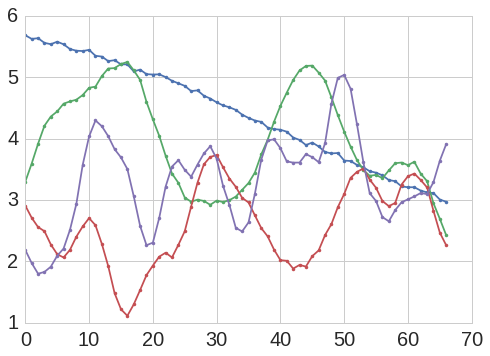

In [676]:
x = np.zeros([nDims,T_max])

length_scales_GP = [10**(.6 if i== 0 else -i*.2) for i in range(nDims)]
params = {
          'l':length_scales_GP
         }
#params = [[4,1,2e0],
#          [1,2,1.5e-1],
#          [6,3,1e0]]

for i,l in enumerate(length_scales_GP):
    
    Ki = calc_K(x=t,y=t,l=l)
    Ki /= np.max(Ki)
    mvn1 = multivariate_normal(mean=[np.random.randint(1,5)]*n_timePoints,cov=Ki)
    x[i] =  mvn1.rvs()#*np.concatenate([np.zeros(5),np.cos(np.linspace(-np.pi/2,0,num=15)),np.ones(T_max-35),np.cos(np.linspace(0,.5*np.pi,num=5)),np.zeros(10)])

for i in range(nDims):
    plt.plot(x[i],'.-')
    
#this is the observed data, which we pretend are the spike trains
rate_params = np.exp(C.dot(x) + d[:,None])
y = np.random.poisson(rate_params + np.abs(np.random.normal(loc=0,scale=1,size=rate_params.shape)))

In [677]:
params = {'C': C,
          'd': d,
          'l': length_scales_GP}

In [678]:
K_big,_ = make_Kbig(params,t)
C_big = make_Cbig(C,t)

In [679]:
xbar = np.array([x.T.flatten()]).T
ybar = np.array([y.T.flatten()])

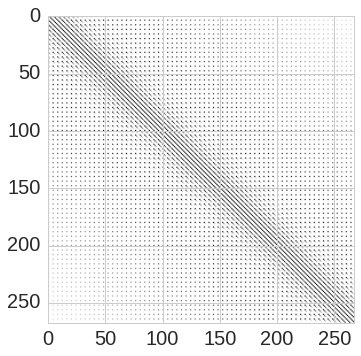

In [680]:
plt.imshow(K_big)

In [681]:
def calc_post_unNorm(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):
    
    """ Code essentially copied from implementation by Hooram Nam"""
    
    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)
    
    L1 = np.dot(np.ones(n_neurons*nT),np.exp(A))
    L2 =  ybar.dot(A)
    L3 =  xbar.T.dot(K_bigInv.dot(xbar))
    p = L1 - L2 + L3 
    return p

def calc_post_grad(xbar, ybar, C_big, d,  K_bigInv,t,n_neurons):

    nT = len(t)
    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    dL1 = np.dot(np.exp(A),C_big)
    dL2 = np.dot(ybar, C_big)
    dL3 = np.dot(xbar.T,  K_bigInv)

    dL = dL1 - dL2 + dL3

    return np.squeeze(dL)


def calc_post_hess(xbar, ybar, C_big, d, K_bigInv,t,n_neurons):
    
    nT = len(t)

    A = np.squeeze(C_big.dot(xbar)) + np.tile(d,nT)

    Aexpdiagonal = sp.sparse.spdiags(np.exp(A),0,n_neurons*nT,n_neurons*nT)
    temp = Aexpdiagonal.dot(C_big)

    ddL = np.dot(C_big.T, temp) +  K_bigInv
    return ddL

In [682]:
nDims = C.shape[1]
nT = len(t)

In [683]:
xInit = xbar#np.zeros(nDims*nT)

In [684]:
K_bigInv = np.linalg.inv(K_big+ np.eye(K_big.shape[0])*1e-3)

In [685]:
####
import scipy.optimize as op
resLap = op.minimize(
    fun = calc_post_unNorm,
    x0 = xInit,
    method='Newton-CG',
    args = (ybar, C_big, d, K_bigInv,t,n_neurons),
    jac = calc_post_grad,
    hess = calc_post_hess,
    options = {'disp': False,'maxiter': 10000})

In [686]:
x_post_mean = resLap.x.reshape(nDims,nT,order='F')

hess = calc_post_hess(resLap.x,  ybar, C_big, d, K_bigInv,t,n_neurons)
PostCovGP = np.linalg.inv(hess)

PostCovGP = PostCovGP 
SD2 = 3*np.sqrt(PostCovGP.diagonal().reshape(nDims,nT,order='F'))

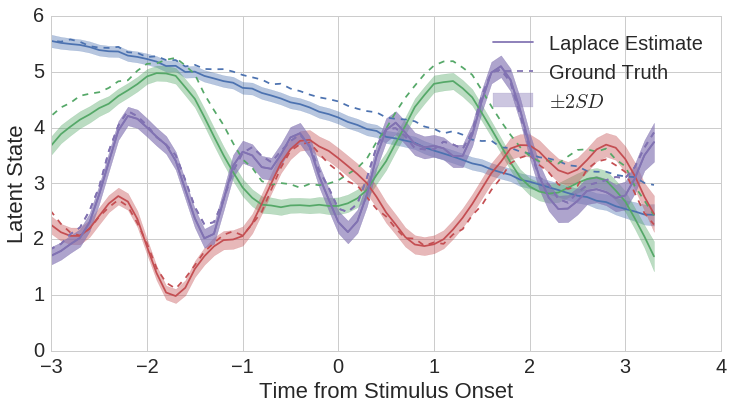

In [687]:
plt.figure(figsize=(12,6))
clrs = seaborn.color_palette(n_colors=nDims)#seaborn.color_palette('RdBu',n_colors=3)

i = 0
for lapInf,gT in zip(x_post_mean,x):
    
    
    plt.plot(t,lapInf,color=clrs[i])
    plt.plot(t,gT,linestyle='--',color=clrs[i])
    plt.fill_between(t,lapInf +SD2[i],lapInf - SD2[i],color=clrs[i],alpha=.4)
    i += 1
    
plt.plot(t,lapInf,color=clrs[i-1],label='Laplace Estimate')
plt.plot(t,gT,linestyle='--',color=clrs[i-1],label='Ground Truth')
plt.fill_between(t,lapInf + SD2[i-1],lapInf - SD2[i-1],color=clrs[i-1],alpha=.4,label=r'$\pm2SD$')

plt.ylabel('Latent State')
plt.xlabel('Time from Stimulus Onset')
plt.xlim(-3)
plt.legend()

#  Now Perform the M-step

In [657]:
temp_vsmGP = np.zeros([nT,nT,nDims])
for kk in range(nDims):
    temp_vsmGP[:,:,kk] = PostCovGP[kk*nT:(kk+1)*nT, kk*nT:(kk+1)*nT]

In [658]:
temp_vsmGP

array([[[  1.92476993e-03,   1.42462721e-03,   2.00701257e-03,
           1.63823600e-03],
        [ -6.33317094e-04,   8.82379829e-05,  -1.20597550e-03,
          -1.93662550e-05],
        [ -5.44448979e-04,  -1.75827951e-04,  -1.91148380e-04,
          -5.86109164e-04],
        ..., 
        [ -5.81507668e-05,  -5.23787336e-06,   5.21195039e-05,
          -5.79974176e-06],
        [  9.80469383e-06,   6.24817971e-06,   3.43195418e-06,
          -4.54415034e-06],
        [  4.09052408e-05,   4.23640517e-06,  -5.84913037e-05,
           1.86880946e-06]],

       [[ -6.33317094e-04,   8.82379829e-05,  -1.20597550e-03,
          -1.93662550e-05],
        [  4.38199429e-03,   9.13264665e-04,   2.41726684e-03,
           2.56068420e-03],
        [ -8.44012062e-04,  -4.19762441e-05,  -3.70492391e-05,
          -6.20396702e-04],
        ..., 
        [  2.42096614e-05,  -1.81319960e-06,  -2.02463853e-06,
          -1.91317632e-05],
        [ -2.03997808e-05,   5.04651838e-05,   1.19753962e-0

##  Code from Macke Lab Hooram Nam (sp?)

In [ ]:
import numpy as np
import scipy.optimize as op

In [ ]:
# Laplace Inference -----------------------------------------------------------
def negLogPosteriorUnNorm(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.ndarray.flatten(np.asarray(xbar))
    ybar = np.ndarray.flatten(np.asarray(ybar))
    T = int(len(d_big)/ydim)

    C_big = np.asarray(C_big)
    d_big = np.asarray(d_big)

    K_bigInv = np.asarray(K_bigInv)

    A = np.dot(C_big.T, xbar) + d_big
    Aexp = np.exp(A)

    L1 = np.dot(Aexp, np.ones(ydim*T))
    L2 = - np.dot(ybar, A.T)
    L3 = 0.5*np.dot(xbar,np.dot(K_bigInv,xbar))

    L = L1 + L2 + L3

    # pdb.set_trace()
    return L

def negLogPosteriorUnNorm_grad(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.asarray(xbar)
    ybar = np.asarray(ybar)

    A = np.dot(C_big.T, xbar) + d_big
    A = np.float64(A)
    Aexp = np.exp(A)

    dL1 = np.dot(Aexp,C_big.T)
    dL2 = - np.dot(ybar, C_big.T)
    dL3 = np.dot(xbar, K_bigInv)

    dL = dL1 + dL2 + dL3

    return dL

def negLogPosteriorUnNorm_hess(xbar, ybar, C_big, d_big, K_bigInv, xdim, ydim):
    xbar = np.asarray(xbar)
    ybar = np.asarray(ybar)

    T = int(len(xbar)/xdim)

    A = np.dot(C_big.T, xbar) + d_big
    A = np.float64(A)

    Aexp = np.exp(A)
    Aexpdiagonal = sp.sparse.spdiags(Aexp,0,ydim*T,ydim*T)
    temp = Aexpdiagonal.dot(C_big.T)

    ddL = np.dot(C_big, temp) + K_bigInv

    return ddL



In [ ]:
def laplace(experiment,
            params,
            prevOptimRes = None,
            returnOptimRes = True,
            verbose = False,
            optimMethod = 'Newton-CG'):
    '''
    laplaceInfRes, -post_lik = laplace(experiment, params)
    '''
    ridge = 0
    
    #here T is the number of bins ydim is the number of neurons
    [ydim,T] = np.shape(experiment.data[0]['Y'])
    [ydim, xdim] = np.shape(params['C'])     #xdim is the number of latent dimensions
    numTrials = len(experiment.data)  # number of trials
    trialDur = experiment.trialDur 
    binSize = experiment.binSize      # size of bins

    # make big parameters
    C_big, d_big = util.makeCd_big(params,T)
    K_big, K = util.makeK_big(params, trialDur, binSize)
    K_bigInv = np.linalg.inv(K_big)
    
    x_post_mean = []
    x_post_cov = []
    x_vsmGP = []
    x_vsm = []

    post_lik = 0
    
    # store current optimization result to use as initialization for inference in next EM iteration
    lapOptimRes = []

    for trial in range(numTrials):
        if verbose: print('laplace inference trajectory of trial ' +str(trial+1) +'...')
        y = experiment.data[trial]['Y']
        ybar = np.ndarray.flatten(np.reshape(y, ydim*T))

        if prevOptimRes == None:
            xInit = np.ndarray.flatten(np.zeros([xdim*T,1]))
        else:
            xInit = prevOptimRes[trial]


            
        ####
        resLap = op.minimize(
            fun = negLogPosteriorUnNorm,
            x0 = xInit,
            method=optimMethod,
            args = (ybar, C_big, d_big, K_bigInv, xdim, ydim),
            jac = negLogPosteriorUnNorm_grad,
            hess = negLogPosteriorUnNorm_hess,
            options = {'disp': False,'maxiter': 10000})
        lapOptimRes.append(resLap.x)
        post_lik = post_lik + resLap.fun
        x_post_mean.append(np.reshape(resLap.x,[xdim,T]))
        hess = negLogPosteriorUnNorm_hess(resLap.x, ybar, C_big, d_big, K_bigInv, xdim, ydim)
        PostCovGP = np.linalg.inv(hess)
        
        PostCovGP = PostCovGP + ridge*np.diag(np.ones(xdim*T))
        x_post_cov.append(PostCovGP)

        temp_vsmGP = np.zeros([T,T,xdim])
        for kk in range(xdim):
            temp_vsmGP[:,:,kk] = PostCovGP[kk*T:(kk+1)*T, kk*T:(kk+1)*T]
        x_vsmGP.append(temp_vsmGP)

        temp_vsm = np.zeros([T,xdim,xdim])
        for kk in range(T):
            temp_vsm[kk][:,:] = PostCovGP[kk::T,kk::T]
        x_vsm.append(temp_vsm)
        # pdb.set_trace()

    post_lik = post_lik / numTrials
    laplaceInfRes = {
        'post_mean': x_post_mean,
        'post_cov' : x_post_cov,
        'post_vsm': x_vsm,
        'post_vsmGP': x_vsmGP}

    if returnOptimRes == True:
        return laplaceInfRes, -post_lik, lapOptimRes
    else:
        return laplaceInfRes, -post_lik


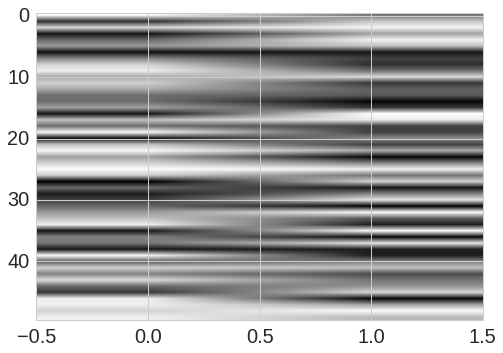

In [170]:
plt.imshow(C,aspect='auto')

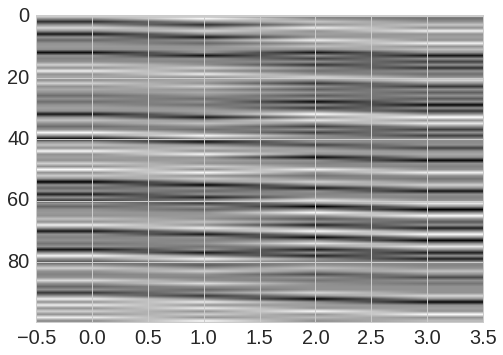

In [171]:
C_big = np.kron(C,np.eye(2))
plt.imshow(C_big,aspect='auto')

In [7]:
def makeK_big(params, trialDur, binSize, epsNoise = 0.001):
    [ydim,xdim] = np.shape(params['C'])
    epsSignal = 1 - epsNoise
    params['tau'] = np.ndarray.flatten(params['tau'])

    T = range(0,int(trialDur/binSize))
    K = np.zeros([xdim, len(T), len(T)])
    K_big = np.zeros([xdim*len(T), xdim*len(T)])
    
    # Make small K (size TxT) for each xdim
    for xd in range(xdim):
        for i in T:
            for j in T:
                K[xd,i,j] = epsSignal*np.exp(-0.5*((T[i]*binSize-T[j]*binSize)**2/(params['tau'][xd]*1000)**2))
        K[xd] = K[xd] + epsNoise * np.eye(len(T))

    # Make big K
    for xd in range(xdim):
        K_big[xd*len(T):(xd+1)*len(T),xd*len(T):(xd+1)*len(T)] = K[xd]
    
    return K_big, K

In [ ]:
    """Parameters:
    ===========
      * xdim       : int, latent dimensionality to fit
      * ydim       : int, number of neurons in the dataset
      * experiment : (optional) If a third optional argument of util.dataset object is given, 
                     the fucntion returns a dictionary of parameters obtained by performing Poisson-
                     PCA Leave this argument empty to initialize randomly.
    Returns:
    ========
         A dictionary of model parameters.
    """
if experiment == None:
    print('Initializing parameters randomly..')
    params = {
        'C': np.random.rand(ydim,xdim)*2 - 1,
        'd': np.random.randn(ydim)*2 - 2,
        'tau': np.random.rand(xdim)*0.5} # seconds